In [1]:
# !git clone https://github.com/AxelThevenot/Python_Benchmark_Test_Optimization_Function_Single_Objective.git
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/src .
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/pybenchfunction/ .
# !ls Python_Benchmark_Test_Optimization_Function_Single_Objective/

In [2]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pybenchfunction as bench
%matplotlib inline

In [3]:
# Functions with sum of terms structure

def LevyN13_i(i,x):
    w = 1+(x-1)/4
    if i==0:
        return  torch.sin(torch.pi*w[0])**2
    else:
        return  ( (w[i-1]-1)**2*(1+10*torch.sin(torch.pi*w[i-1]+1)**2)+ (w[-1]-1)**2*(1+torch.sin(2*torch.pi*w[-1])**2)         )

def PermDBeta_i(i,x):
    beta=0.5  # Added default value for beta
    v = 0
    # j = np.arange(1, d+1)
    # j = range(1,d+1)
    # v = torch.sum(((j**(i+1) + beta) *((x/j)**(i+1) - 1))**2 ) 
    for j in range(d):
        # v+=(1+j+beta)*(x[j]**(i+1) -1. / (j+1)**(i+1))   
        # v+=(1+j+beta)*(x[j]/(j+1)**(i+1))  
        v+= (((j+1)**(i+1) + beta) *((x[j]/(j+1))**(i+1) - 1))**2 
    return v

# def __call__(self, X):
#         d = X.shape[0]
#         j = np.arange(0, d)
#         res = np.sum([np.sum(((j+1)**(i+1) +(j+1)**(i)* self.beta) *((X/(j+1))**(i+1) - 1))**2  for i in range(0, d)])
#         return res

def Rastrigin_i(i,x):
    v = 10+x[i]**2-10*torch.cos(2*torch.pi*x[i])
    return v
    
def RosenBrock_i(i,x):
    b = 100
    a = 1
    return b * (x[i] - x[i - 1] ** 2) ** 2 + (a - x[i]) ** 2   


In [4]:

def run_SP2plus(computeValue, epochs=20, d=2, lr =1.0, x0=None):

    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = torch.clone(x0)
    gdiffHvg = torch.zeros(d, requires_grad=False).double()*1
    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    y_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]
            hessvgrad = torch.autograd.functional.hvp(funci, x, grad, create_graph=True)[1]
            # print(hessvgrad.shape)
            # hessian_grad = torch.autograd.grad(grads, self.params, grad_outputs=grads)
            with torch.no_grad():
                gradnormsqr = torch.norm(grad)**2
                # if gradnormsqr > 1e-18:
                sps_step = fi/gradnormsqr
                x.sub_(sps_step*grad, alpha = lr)
                # gdiffHvg = grad -hessvgrad*fi/gradnormsqr
                gdiffHvg = torch.sub(grad, hessvgrad, alpha= sps_step)
                # gdiffHvg = [g - fi*hg/gradnormsqr for g,hg in zip(grad, hessvgrad)]   # Maybe need this instead?
                if torch.norm(gdiffHvg)**2 > 1e-10:
                    x.sub_(0.5*(sps_step**2)*gdiffHvg*torch.dot(grad,gdiffHvg)/ (torch.norm(gdiffHvg)**2), alpha = lr)
        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        x_list.append(x[0].item())
        y_list.append(x[1].item())
        
    return [x_list, y_list] , fval

def run_SP2(computeValue, epochs=20, d=2, lr =1.0, inner_steps = 10, x0=None):
    
    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = torch.clone(x0)
    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    y_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]
           
            # hessian = torch.autograd.functional.hessian(pow_reducer, inputs)
            # print(hessvgrad.shape)
            # hessian_grad = torch.autograd.grad(grads, self.params, grad_outputs=grads)
            w = torch.clone(x)
            for j in range(inner_steps):
                wdiff = torch.sub(w,x)
                hessvgrad = torch.autograd.functional.hvp(funci, x, wdiff, create_graph=True)[1]
                with torch.no_grad():
                    q = fi + torch.dot(grad,wdiff) +0.5*torch.dot(wdiff,hessvgrad)
                    nablaq = torch.add(grad,hessvgrad)
                    nablaqnorm = torch.norm(nablaq)
                    if nablaqnorm <1e-22:
                        break
                    w.sub_(nablaq , alpha = lr*q/nablaqnorm**2)
            with torch.no_grad():
                # x = torch.clone(w)
                x = w
        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        x_list.append(x[0].item())
        y_list.append(x[1].item())
        
    return [x_list, y_list] , fval

def run_SGD(computeValue, epochs=20, d=2, lr =1.0, x0=None):

    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = torch.clone(x0)

    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    y_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]

            with torch.no_grad():
                x.sub_(grad, alpha=lr)

        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        x_list.append(x[0].item())
        y_list.append(x[1].item())        
    return [x_list, y_list] , fval

def run_newton(computeValue, epochs=20, d=2, lr =1.0, x0=None):

    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = torch.clone(x0)

    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    y_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        grad = torch.zeros(d)
        hess = np.zeros([d,d])
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad_i = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]
            grad.add_(grad_i)
            
            #populate the hessian for fi
            hess_i = np.zeros([d,d])
            for j in range(d):
                Hj = torch.autograd.grad(grad_i[j],x,retain_graph=True)[0]
                hess_i[:,j]=Hj
            hess_i = 0.5*(hess_i + hess_i.T) #symmetrize in case of rounding errors?
            hess = hess + hess_i

        with torch.no_grad():
            newton_step = torch.tensor(np.linalg.solve(hess,grad.numpy()))
            # newton_step = torch.linalg.solve(grad, hess)
            # newton_step = torch.tensor(np.linalg.inv(hess) @ grad.numpy())
            x.sub_(newton_step)
        

        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))     
        x_list.append(x[0].item())
        y_list.append(x[1].item())        
        
    return [x_list, y_list] , fval

In [5]:
font = {'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)

def plot_level_set_results(bench_function, x_lists):
    labels = ['SP2plus', 'SP2', 'SGD', 'Newton']
    colors = ['g', 'b', 'y', 'r']
    markers = ["x", "o", "2" , "P"]
    # bench.plot_3d(thevenot, n_space=100, ax=None,show=False)
    bench.plot_2d(bench_function, n_space=100, ax=None, show=False)
    X_domain, Y_domain = bench_function.input_domain
    X_min, minimum = bench_function.get_global_minimum(2)
    plt.plot(X_min[0],X_min[1],'*', markersize=10, color='yellow')
    for x_list, color, marker, label in zip(x_lists, colors, markers, labels):
        plt.scatter(x_list[0],x_list[1], s=20, label = label, zorder=1, color = color, marker=marker)
    plt.xlim(X_domain)
    plt.ylim(Y_domain) 
    plt.tight_layout()
    plt.savefig(bench_function.name + '-2d.pdf', bbox_inches='tight', pad_inches =0)
    plt.show()


    bench.plot_3d(bench_function, n_space=100, ax=None, show=False)
    plt.plot(X_min[0],X_min[1],'*', markersize=12, color='yellow')
    
    for x_list, color, marker, label in zip(x_lists, colors, markers, labels):
        plt.scatter(x_list[0],x_list[1], s=20, label = label, zorder=1, color = color, marker=marker)
    plt.xlim(X_domain)
    plt.ylim(Y_domain) 
    plt.tight_layout()
    plt.savefig(bench_function.name + '-3d.pdf', bbox_inches='tight', pad_inches =0)
    plt.show()


def plot_function_values(bench_function, SP2plus_fval, SP2_fval, SGD_fval, newt_fval ):
    # ['bs', 'yd','r+']
    linewidth =3
    plt.plot(SP2plus_fval, 'g' , label='SP2plus', linewidth=linewidth )
    plt.plot(SP2_fval, 'b', label='SP2', linewidth=linewidth)
    plt.plot(SGD_fval, 'y', label='SGD', linewidth=linewidth )
    plt.plot(newt_fval, 'r', label='Newton', linewidth=linewidth)

    plt.ylabel('function value')
    plt.xlabel('iterations')
    plt.yscale('log')
    plt.legend()
    plt.savefig(bench_function.name + '-funcs.pdf',bbox_inches='tight', pad_inches =0)
    plt.show()

In [6]:
d=2
epochs = 100
x0 = torch.ones(d, requires_grad=True).double() *2.0
fi = LevyN13_i
ffull  = bench.function.LevyN13(d)
# SP2_x_list, SP2_fval  =run_SP2plus(fi, epochs=epochs, x0=x0, d=d, lr=0.5) SP2plus_fval, SP2_fval
SP2plus_x_list, SP2plus_fval  =run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
SP2_x_list, SP2_fval  =run_SP2(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
SGD_x_list, SGD_fval  =run_SGD(fi, epochs=epochs, x0 = x0,d=d, lr=1.0)
newt_x_list, newt_fval=run_newton(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
plot_function_values(ffull, SP2plus_fval, SP2_fval, SGD_fval, newt_fval)
plot_level_set_results(ffull,[SP2plus_x_list, SP2_x_list, SGD_x_list, newt_x_list] ) 

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
d=2
epochs = 200
x0 = -2*torch.randn(d, requires_grad=True).double()
fi = PermDBeta_i
ffull  = bench.function.PermDBeta(d)
SP2plus_x_list, SP2plus_fval  =run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
SP2_x_list, SP2_fval  =run_SP2(fi, epochs=epochs, x0 = x0, d=d, lr=0.5)  # Slowing down SP2 just so we can see it on surface plot! Otherwise it jumps to the solution!
SGD_x_list, SGD_fval  =run_SGD(fi, epochs=epochs, x0 = x0,d=d, lr=0.01)
newt_x_list, newt_fval=run_newton(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
plot_function_values(ffull, SP2plus_fval, SP2_fval, SGD_fval, newt_fval)
plot_level_set_results(ffull,[SP2plus_x_list, SP2_x_list, SGD_x_list, newt_x_list] ) #['b', 'o','g']


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

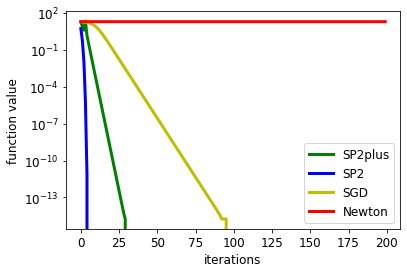

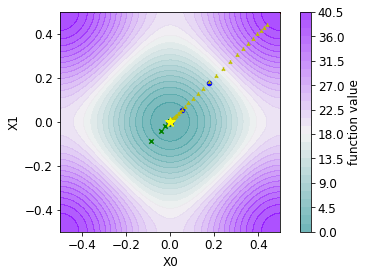

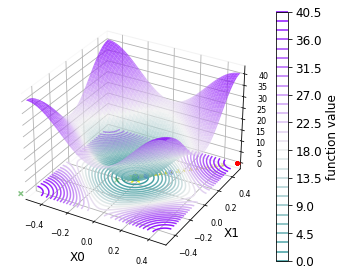

In [ ]:
d=2
epochs = 200
x0 = torch.ones(d, requires_grad=True).double() *0.45
fi = Rastrigin_i
ffull  = bench.function.Rastrigin(d)
SP2plus_x_list, SP2plus_fval  =run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
SP2_x_list, SP2_fval  =run_SP2(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
SGD_x_list, SGD_fval  =run_SGD(fi, epochs=epochs, x0 = x0,d=d, lr=0.0005)
newt_x_list, newt_fval=run_newton(fi, epochs=epochs, x0 = x0, d=d, lr=1.0)
plot_function_values(ffull, SP2plus_fval, SP2_fval, SGD_fval, newt_fval)
plot_level_set_results(ffull,[SP2plus_x_list, SP2_x_list, SGD_x_list, newt_x_list] ) 

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

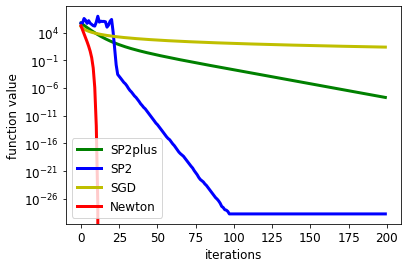

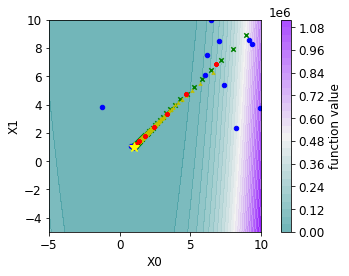

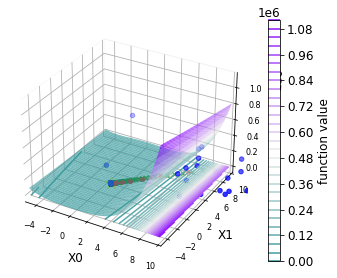

In [ ]:
d=2
epochs = 200
x0 = torch.ones(d, requires_grad=True).double() *10
fi = RosenBrock_i
ffull  = bench.function.Rosenbrock(d)
SP2plus_x_list, SP2plus_fval  =run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=0.5)
SP2_x_list, SP2_fval  =run_SP2(fi, epochs=epochs, x0 = x0, d=d, lr=0.5, inner_steps=10)
SGD_x_list, SGD_fval  =run_SGD(fi, epochs=epochs, x0 = x0,d=d, lr=0.00001)
newt_x_list, newt_fval=run_newton(fi, epochs=epochs, x0 = x0, d=d, lr=0.5)
plot_function_values(ffull, SP2plus_fval, SP2_fval, SGD_fval, newt_fval)
plot_level_set_results(ffull,[SP2plus_x_list, SP2_x_list, SGD_x_list, newt_x_list] ) 
